In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn, optim
from torchvision import datasets, transforms

import zipfile

import shutil
import os
import pandas as pd

device = ("cuda" if torch.cuda.is_available() else "cpu") # Use GPU or CPU for training

In [2]:
class AlexNet(nn.Module):

    def __init__(self, num_classes: int = 2):
        super(AlexNet, self).__init__()

        self.convolutional = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

        self.linear = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 2)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        x = self.convolutional(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.linear(x)
        return torch.softmax(x, 1)

In [3]:
model = AlexNet()
model = model.to(device)

In [4]:
'''with zipfile.ZipFile("celeba.zip","r") as zip_ref:
  zip_ref.extractall("data_faces/")'''

'with zipfile.ZipFile("celeba.zip","r") as zip_ref:\n  zip_ref.extractall("data_faces/")'

In [5]:

root = '/home/luser/autoencoder_attacks/train_aautoencoders/data_faces/img_align_celeba'
img_list = os.listdir(root)
print(len(img_list))

202599


In [6]:

df = pd.read_csv("/home/luser/autoencoder_attacks/train_aautoencoders/list_attr_celeba.csv")
df = df[['image_id', 'Male']]

In [7]:
df
#get all the row titles
df.index
# get all the column titles
df.columns

Index(['image_id', 'Male'], dtype='object')

In [8]:
# to make directories

'''!rm -rf data
!mkdir data && mkdir data/male && mkdir data/no_male'''

'!rm -rf data\n!mkdir data && mkdir data/male && mkdir data/no_male'

In [9]:

s0 = 0
s1 = 0

num = 1000000

for i, (_, i_row) in enumerate(df.iterrows()):
  if s0 < num:
    if i_row['Male'] == 1:
      s0 += 1
      shutil.copyfile('/home/luser/autoencoder_attacks/train_aautoencoders/data_faces/img_align_celeba/' + i_row['image_id'], 'data/male/' + i_row['image_id'])
  
  if s1 < num:
    if i_row['Male'] == -1:
      s1 += 1
      shutil.copyfile('/home/luser/autoencoder_attacks/train_aautoencoders/data_faces/img_align_celeba/' + i_row['image_id'], 'data/no_male/' + i_row['image_id'])
  
  if s0 == num and s1 == num:
    break

In [10]:

img_list = os.listdir('data/male/')
img_list.extend(os.listdir('data/no_male/'))

In [11]:
print("Images: ", len(img_list))


Images:  202599


In [12]:

transform = transforms.Compose([
          transforms.Resize((64, 64)),
          transforms.ToTensor()
          ])

batch_size = 64
celeba_data = datasets.ImageFolder('data', transform=transform)

In [13]:
print(celeba_data.classes)
print(len(celeba_data))

['male', 'no_male']
202599


In [14]:

train_set, test_set = torch.utils.data.random_split(celeba_data, [int(len(img_list) * 0.75), len(img_list) - int(len(img_list) * 0.75)])
train_data_size = len(train_set)
test_data_size = len(test_set)

In [15]:
trainLoader = torch.utils.data.DataLoader(train_set,batch_size=batch_size, shuffle=True)
testLoader  = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

In [16]:
print(train_data_size)
print(test_data_size)

151949
50650


In [17]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [18]:
epochs = 10
train_loss = []

for epoch in range(epochs):
   
    total_train_loss = 0
    
    # training our model
    for idx, (image, label) in enumerate(trainLoader):
        image, label = image.to(device), label.to(device)

        optimizer.zero_grad()
        pred = model(image)

        loss = criterion(pred, label)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    total_train_loss = total_train_loss / (idx + 1)
    train_loss.append(total_train_loss)

    print(f'Epoch: {epoch} | Train Loss: {total_train_loss}')

Epoch: 0 | Train Loss: 0.40827546765929773
Epoch: 1 | Train Loss: 0.3710144022389462
Epoch: 2 | Train Loss: 0.3649670090047937
Epoch: 3 | Train Loss: 0.3606458044805025
Epoch: 4 | Train Loss: 0.35701302197105006
Epoch: 5 | Train Loss: 0.3538848352808701
Epoch: 6 | Train Loss: 0.35223924461163975
Epoch: 7 | Train Loss: 0.3504576661712245
Epoch: 8 | Train Loss: 0.3498131885905015
Epoch: 9 | Train Loss: 0.34826573493606167


In [19]:
torch.save(model.state_dict(), '/home/luser/robustness_of_subgroups/saved_gender_classifier/gender_classifier.torch')

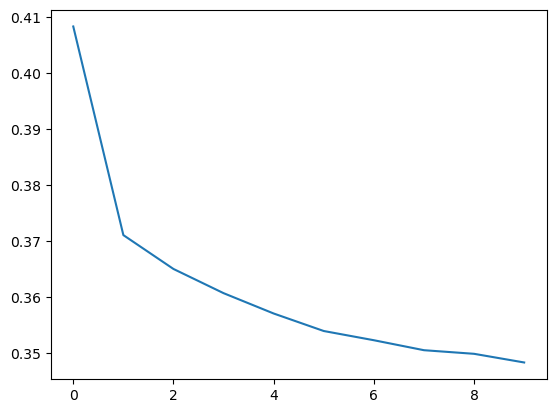

In [20]:
plt.plot(train_loss)


In [21]:
testiter = iter(testLoader)
images, labels = next(testiter)

with torch.no_grad():
  images, labels = images.to(device), labels.to(device)
  pred = model(images)

images_np = [i.cpu() for i in images]
class_names = celeba_data.classes

In [22]:
pred.shape

torch.Size([64, 2])

In [23]:
for i in range(len(pred)):
    print(labels[i] == torch.max(pred[i], 0)[1])

tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(Tr

In [24]:
np.argmax(pred.cpu().numpy(), 1), labels

(array([1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1,
        1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0]),
 tensor([1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1,
         1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
         0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1], device='cuda:0'))

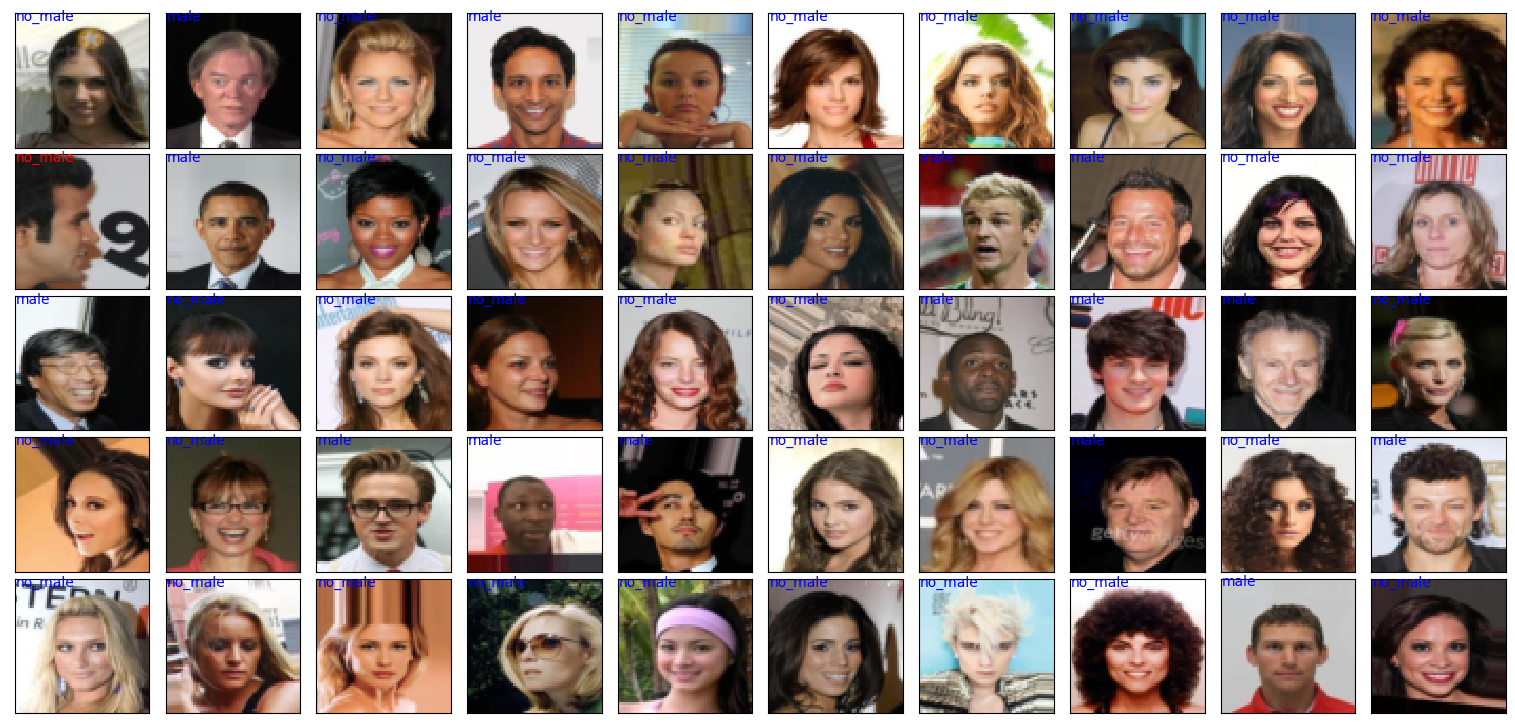

In [25]:

fig = plt.figure(figsize=(15, 7))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(50):
    ax = fig.add_subplot(5, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(images_np[i].permute(1, 2, 0), cmap=plt.cm.gray_r, interpolation='nearest')

    if labels[i] == torch.max(pred[i], 0)[1]:
      ax.text(0, 3, class_names[torch.max(pred[i], 0)[1]], color='blue')
    else:
      ax.text(0, 3, class_names[torch.max(pred[i], 0)[1]], color='red')